# Контекст

---
Возможные метрики:

- R2 (коэффициент детерминации)
    - показывает насколько лучше наша модель по сравнению с горизонтальной прямой по среднему
    - обычно значение R2 = [0;1] (1 - идеально, 0 - ужас)
    - может быть отрицательной, если модель хуже чем горизонтальная прямая по среднему


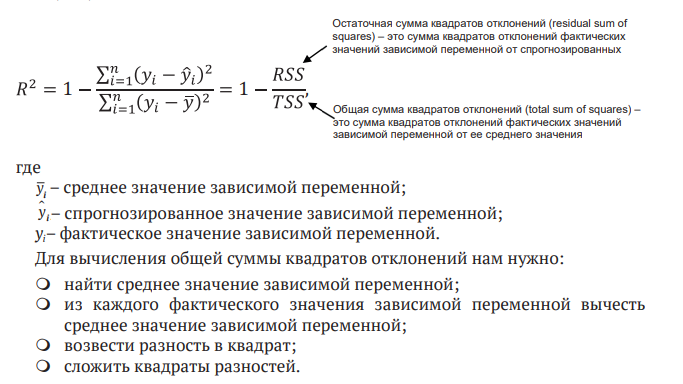

- MAE (срене-абсолютная ошибка)
- Median AE
- MSE
- MSLE (аналог MSE, но предпочтение дается, в точ числе, малым ошибкам)
---
Методы анализа временных данных:

- сглаживание (скользящим средним): позволяет посмотреть на динамику изменения величины не всегда заметную глазу
- экспоненциальное сглаживание (Используется для модели Holt-Winter)
- тест Дики-Фуллера (тест на стационарность, но не всегда хорошо учитывает сезонность)
- автокорреляция (также нужен для отслеживания сезонности, и как следствие, помогает убрать стационарность)
- частичная автокорреляция - она измеряет корреляцию между переменной и ее прошлыми значениями, одновременно контролируя влияние промежуточных переменных. 
    - помогает подобрать параметры для модели ARIMA
    - графики PACF могут помочь обнаружить сезонность во временных рядах. Если график PACF показывает значительные всплески через регулярные промежутки времени, это может указывать на наличие сезонности.
    - Проверка модели : графики PACF можно использовать для проверки адекватности модели ARIMA. Если остатки модели не показывают значительной автокорреляции, это может указывать на то, что модель адекватна.
---
Признаки, которые можно использовать:

- лаги временных рядов
- статистика окон
    - Макс/мин значение серии в окне
    - Среднее/медианное значение в окне
    - дисперсия окна (отклонение)
- Функции даты и времени
    - Минута часа, час дня, день недели и т. д.
    - Этот день праздник? Может быть, какое-то особенное событие? Представьте это как логическую функцию
- Целевая кодировка
- Прогнозы от других моделей
---
Описание данных:

ads.csv

- Time (dataseries (час))
- Ads (кол-во рекламы просмотренной в час)



In [19]:
import warnings
import time                         
warnings.filterwarnings('ignore')


import numpy as np                    
import pandas as pd                     
import matplotlib.pyplot as plt
import seaborn as sns                          

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.metrics import mean_absolute_error,\
                            mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit,\
                                    cross_val_score
from sklearn.linear_model import LinearRegression,\
                                 RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV

import catboost as cb
from itertools import product
from tqdm import tqdm_notebook



import numpy as np
import torch
from torch import nn
import torch.optim as optim


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Куда ?: ', torch.cuda.is_available())

%matplotlib inline

Куда ?:  True


# Чтение данных Ads (просмотренной рекламы в час)

In [2]:
ads = pd.read_csv(
    'ads.csv',
    index_col = ['Time'],
    parse_dates = ['Time'] # Преобразование столбца времени в datetime
    )
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


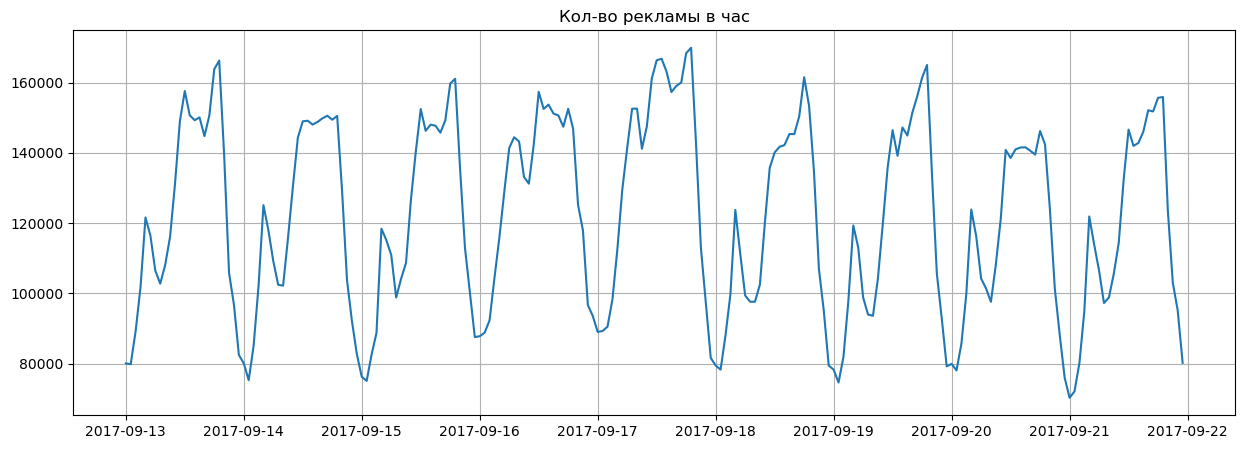

In [3]:
plt.figure(figsize=(15, 5))
plt.plot(ads['Ads'])
plt.title('Кол-во рекламы в час')
plt.grid(True)
plt.show()

# Построение графика скользящего среднего (сглаживание, для выявления динамики значений во времени)

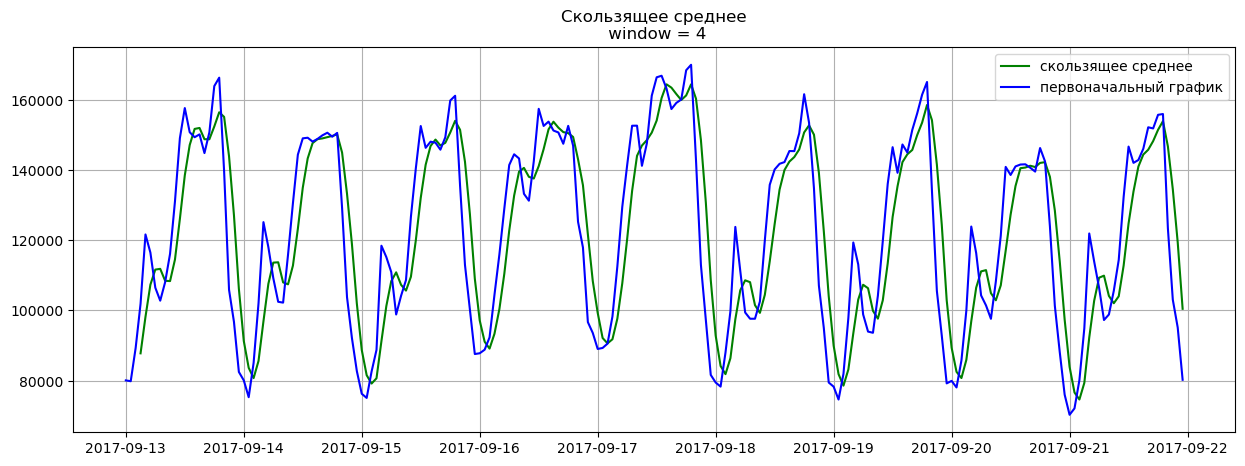

In [6]:
def rolling_mean_plot(data,window, plot_conf_intervals = False, scale = 1.96, plot_anomalies = True):
    ''' 
    data (pd.DataFrame) фрейм с индексами времени
    window (int) окно скольжения
    '''
    rolling_mean = data.rolling(window = window).mean()

    plt.figure(figsize = (15, 5))
    plt.title('Скользящее среднее\n window = {}'.format(window))
    # Построение графика скользящего среднего
    plt.plot(
        rolling_mean,
        color = 'g',
        label = 'скользящее среднее'
    )
    # Построение изначального графика 
    plt.plot(
        data,
        color = 'b',
        label = 'первоначальный график'
    )
    
    if plot_conf_intervals:
        mae = mean_absolute_error(data[window:], rolling_mean[window:])
        deviation = np.std(data[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="нижняя / верхняя границы дов. инт.")
        plt.plot(lower_bond, "r--")
    
        if plot_anomalies:
                anomalies = pd.DataFrame(index = data.index, columns = data.columns)
                anomalies[data<lower_bond] = data[data<lower_bond]
                anomalies[data>upper_bond] = data[data>upper_bond]
                plt.plot(anomalies, "ro", markersize=10, label = 'аномалия')

    plt.legend(loc='best')
    plt.grid(True)

rolling_mean_plot(ads, 4)

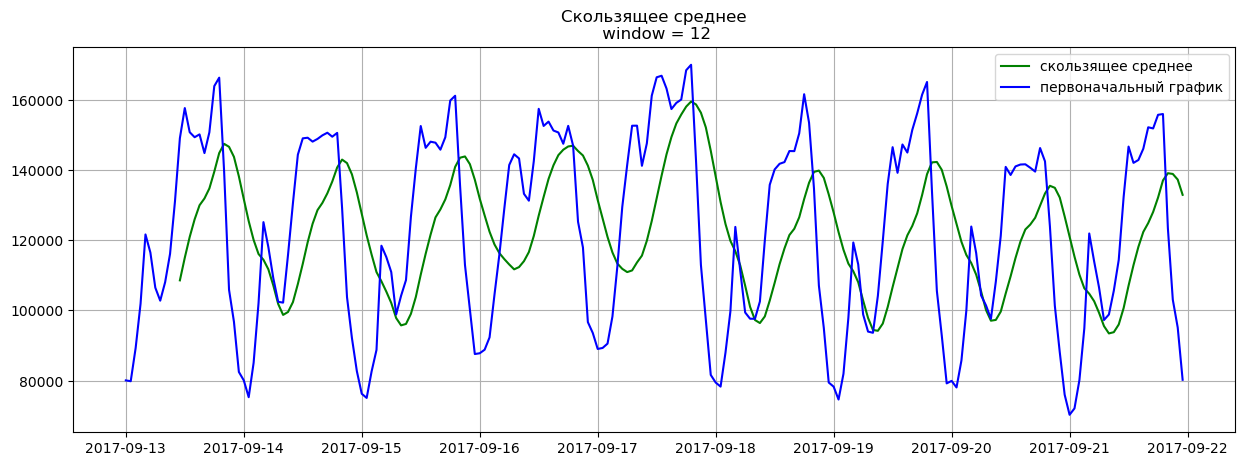

In [7]:
rolling_mean_plot(ads, 12)

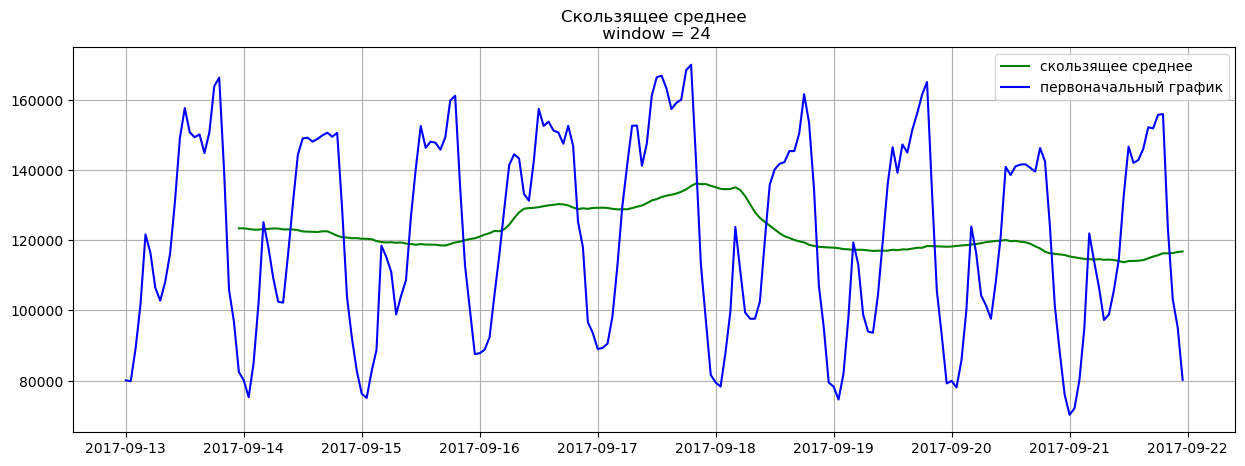

In [8]:
rolling_mean_plot(ads, 24)

Скользящее среднее (сглаживание по нему) позволяет посмотреть на динамику изменения величины не всегда заметную глазу

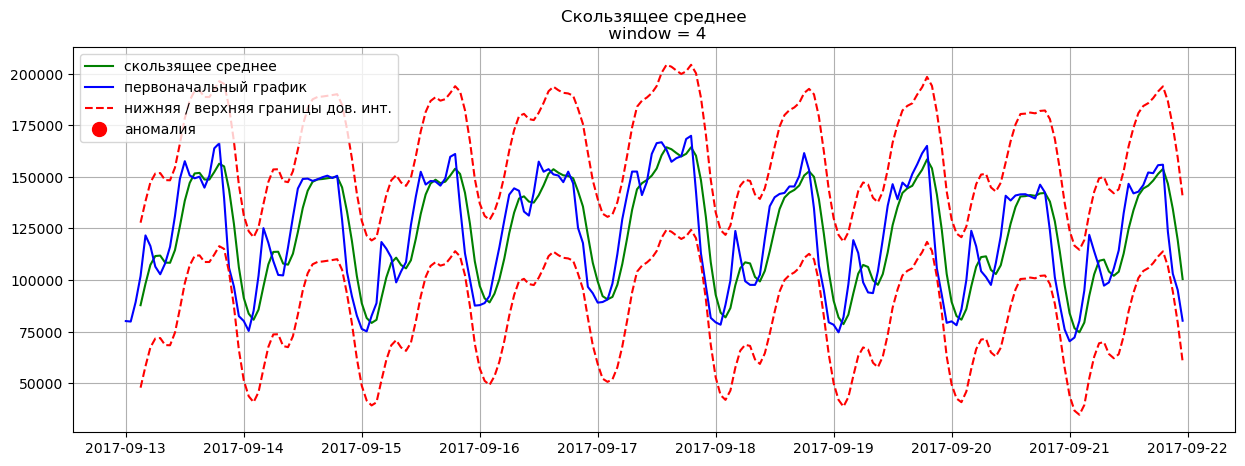

In [9]:
rolling_mean_plot(
    data = ads,
    window = 4,
    plot_conf_intervals = True
)

# Экспоненциальное сглаживание

это метод анализа временных рядов, который использует взвешенное среднее предыдущих значений для прогнозирования будущих значений. Он использует экспоненциально убывающие веса для учета более ранних наблюдений с меньшим весом.

## Функция подсчета экспоненциального сглаживания

In [11]:
def exponential_smoothing(data, alpha):
    """
        data (pd.DataFrame) фрейм с индексами времени
        alpha - float [0.0, 1.0] коэффициент сглаживания
    """
    
    result = [*data.values[0]]
    for n in range(1, len(data)):
        result.append(alpha * data.iloc[n][0] + (1 - alpha) * result[n-1])
    return result

## Функция построения экспоненциально-сглаженного графика

Просто ознакомление. Используется для модели Holt-Winter

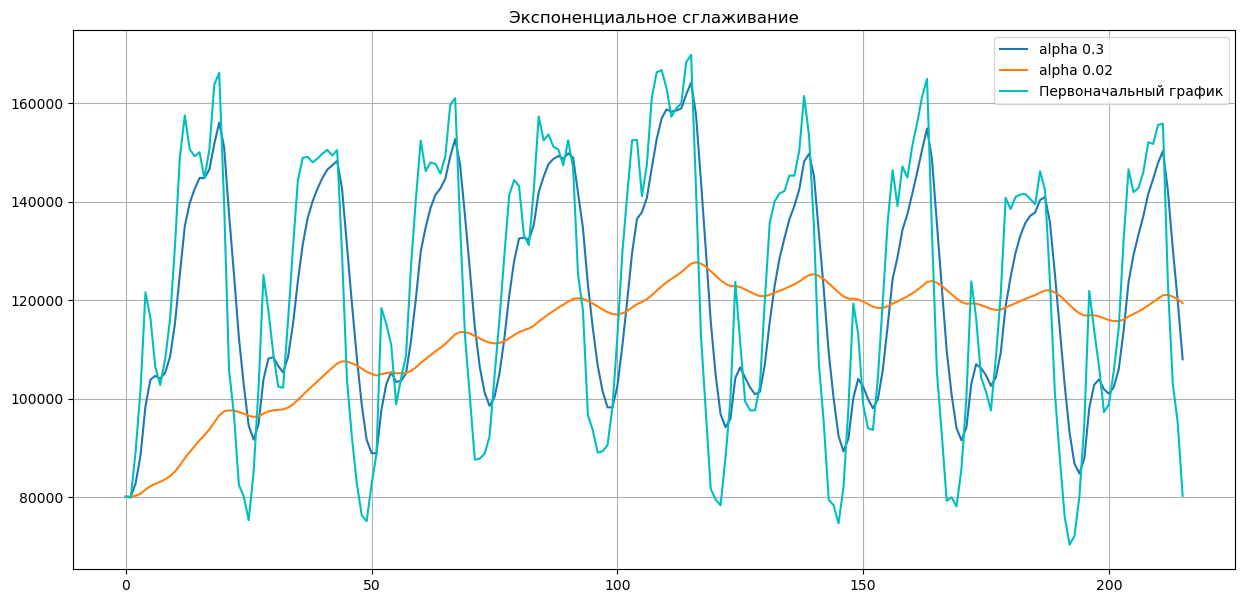

In [12]:
def plot_exp_smooth(data, alphas):
    """
    data (pd.DataFrame) фрейм с индексами времени
    alphas - (list of floats) список параметров сглаживания 
    """

    plt.figure(figsize=(15, 7))
    for alpha in alphas:
        plt.plot(exponential_smoothing(data, alpha), label="alpha {}".format(alpha))
    plt.plot(data.values, "c", label = "Первоначальный график")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Экспоненциальное сглаживание")
    plt.grid(True);

plot_exp_smooth(ads, [0.3, 0.02])


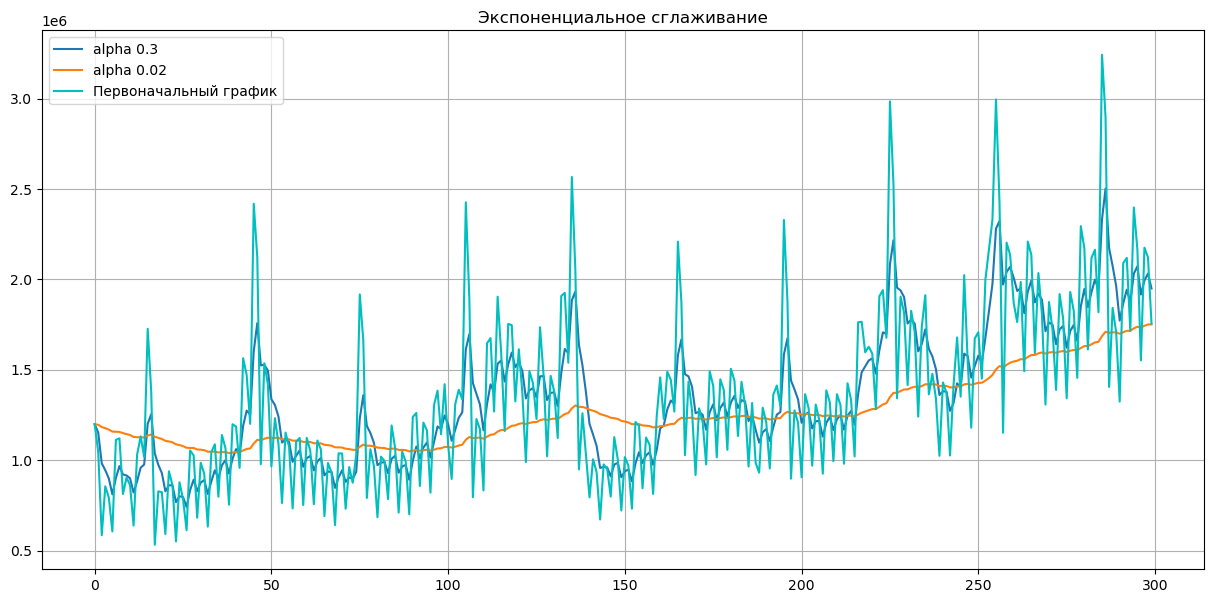

In [13]:
plot_exp_smooth(currency, [0.3, 0.02])

# Проверка на стационарность

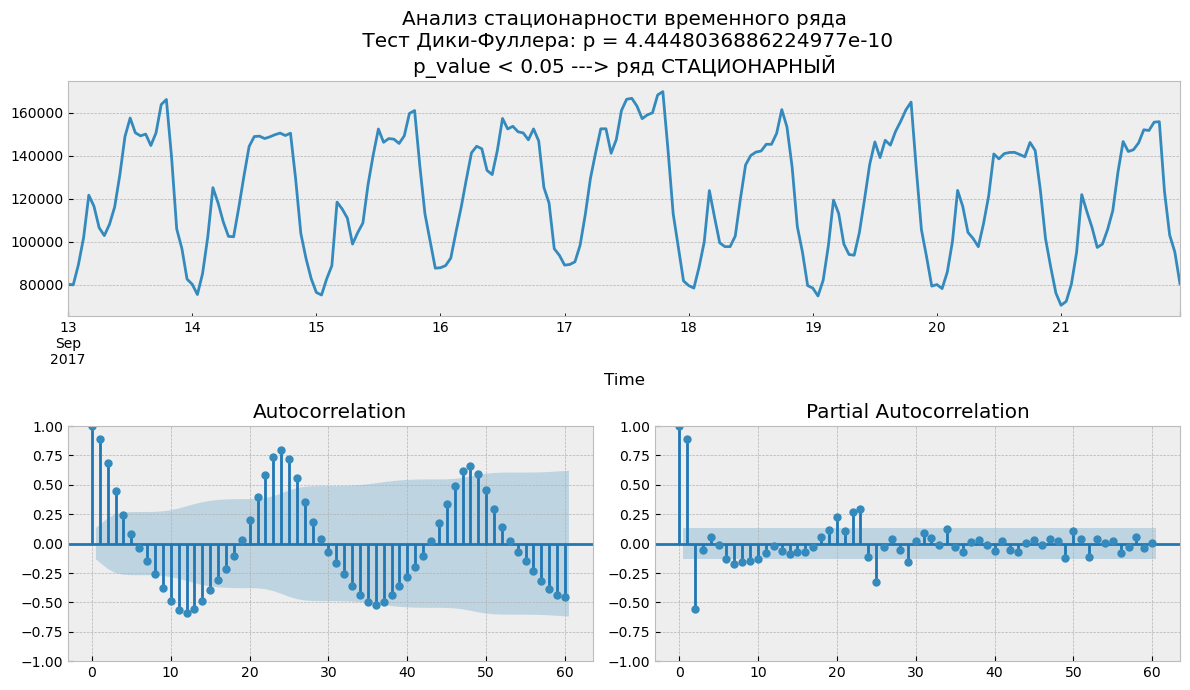

In [14]:
def stationarity_analist(y, lags=None, figsize=(12, 7), style='bmh', alpha = 0.05):
    """

        y (pd.Series) колонка значений
        lags (int) кол-во лагов при построении ACF и PACF
    """
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        if p_value < alpha:
            ts_ax.set_title('Анализ стационарности временного ряда\n Тест Дики-Фуллера: p = {}\np_value < {} ---> ряд СТАЦИОНАРНЫЙ'.format(p_value, alpha))
        else:
            ts_ax.set_title('Анализ стационарности временного ряда\n Тест Дики-Фуллера: p = {}\np_value > {} ---> ряд НЕ СТАЦИОНАРНЫЙ'.format(p_value, alpha))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


stationarity_analist(ads['Ads'], 60)

Тест показывает, что ряд стационарный, но сезонность присутствует (каждые 24 часа) ---> тест Дики-Фуллера не всегда показывает действительность стационарности

# Устранение сезонности

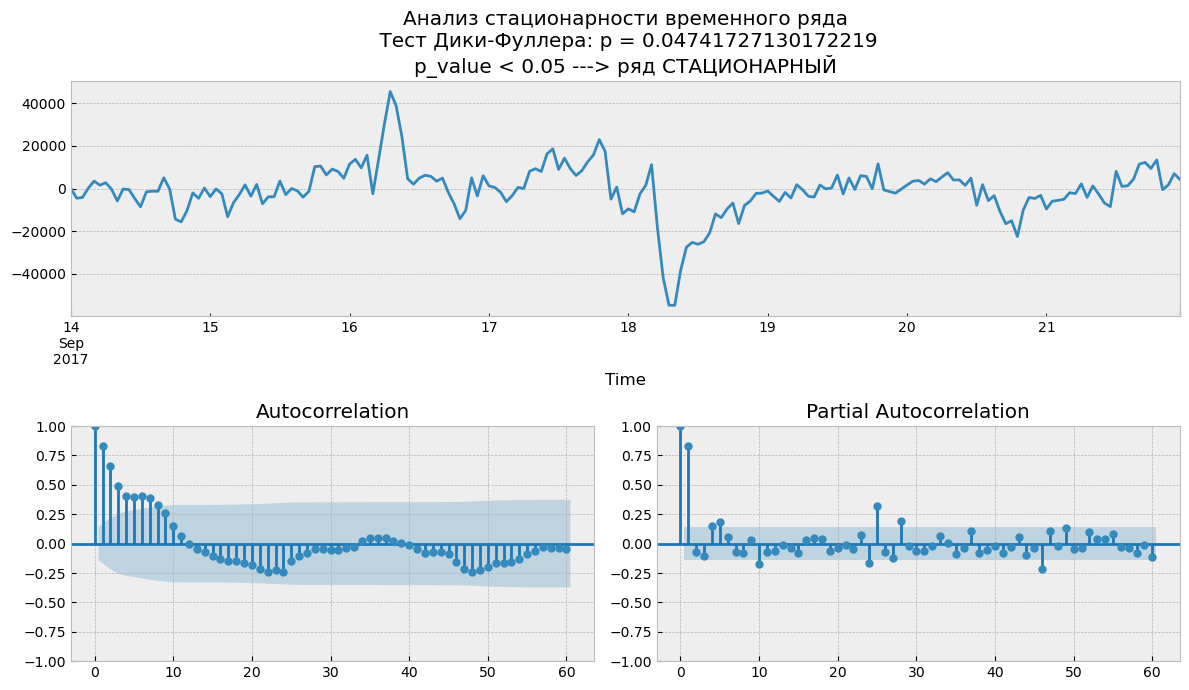

In [15]:
ads_diff = ads['Ads'] - ads['Ads'].shift(24)
stationarity_analist(ads_diff[24:],  lags = 60)

- Ряд стационарный (причем тест показывает близость p_value к alpha (близка вероятность ошибки))
- видим что сезонность исчезла (на основном графике)
- но на графике автокорреляции все еще прослеживается элементы сезонности

Сделаем еще шажок вычитания (shift(1))

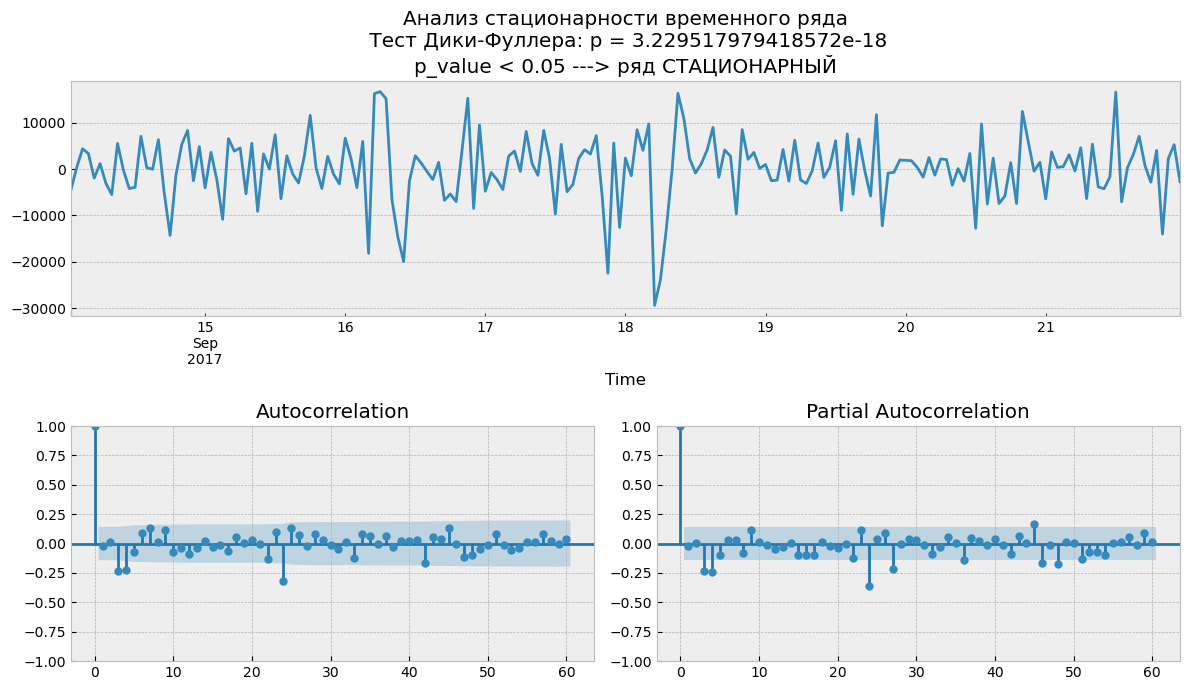

In [16]:
ads_diff = ads_diff - ads_diff.shift(1)
stationarity_analist(ads_diff[25:], lags=60)

Теперь сезонность устранена на всех графиках и ряд действительно стационарен

# Feature extraction

In [17]:
data = ads.copy()
data.columns = ['target']
data.head()

,target
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


## Lag

In [18]:
for i in range(6, 25):
    data['lag_{}'.format(i)] = data.target.shift(i)

data.tail(5)

,target,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0


### Train - val - test

In [6]:
time_series_cross_val = TimeSeriesSplit(n_splits = 5)

In [7]:
def time_series_train_test_split(X, y, test_size):

    test_index = int(len(X)*(1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [ ]:
y = data.dropna().target
X = data.dropna().drop(['target'], axis = 1)

X_train, X_test, y_train, y_test = time_series_train_test_split(X, y, test_size = 0.3)

### Linear model

In [22]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [23]:
lr_model.coef_

array([ 0.04978632, -0.09098203,  0.01587274,  0.0321009 , -0.0628224 ,
        0.0399519 , -0.06644523, -0.02481202, -0.0139989 , -0.07712245,
        0.0180196 , -0.00855115, -0.02000835, -0.05100416,  0.01050642,
        0.03617653, -0.10321449,  0.16143275,  0.68712724])

## Построение результатов линейной модели

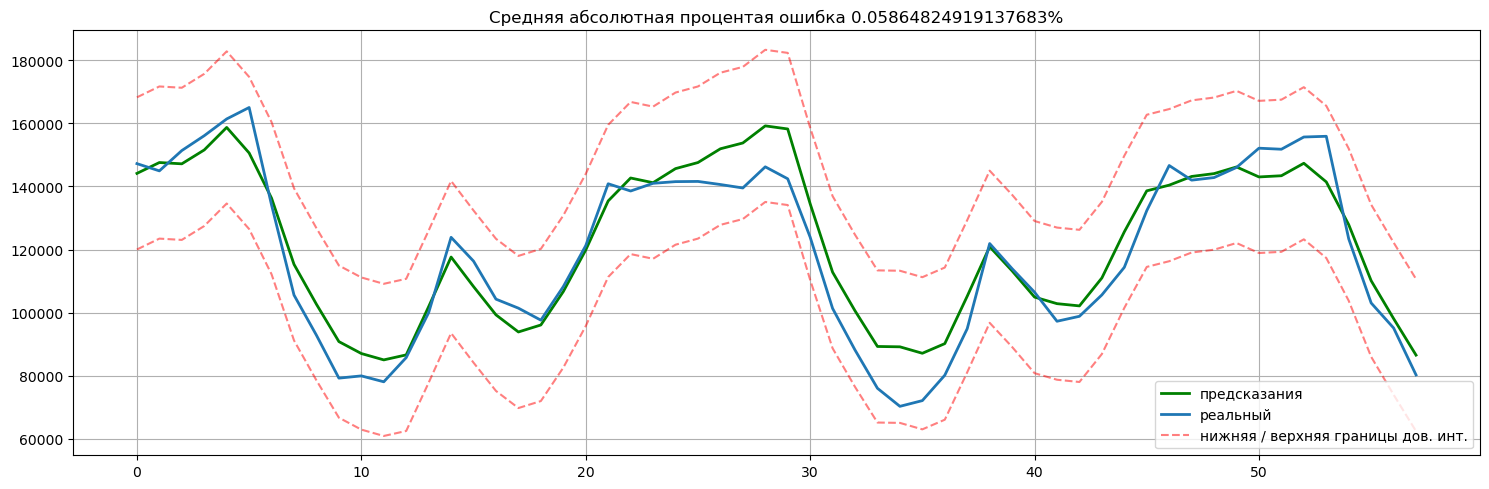

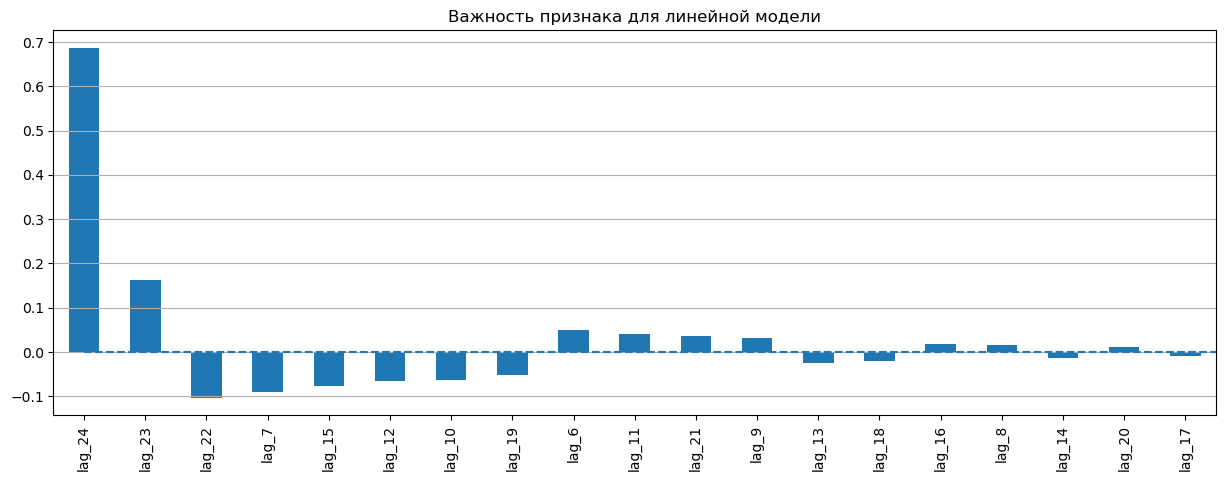

In [24]:
def plot_model_results(model, X_train=X_train, X_test=X_test, plot_conf_intervals=False, plot_anomalies=False):

    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 5))
    plt.plot(prediction, "g", label = "предсказания", linewidth = 2.0)
    plt.plot(y_test.values, label = "реальный", linewidth = 2.0)
    
    if plot_conf_intervals:
        cv = cross_val_score(
            model, X_train, y_train, 
            cv = time_series_cross_val, 
            scoring = "neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label = "нижняя / верхняя границы дов. инт.", alpha = 0.5)
        plt.plot(upper, "r--", alpha = 0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize = 10, label = "аномалии")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Средняя абсолютная процентая ошибка {}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    



def plot_coeff_regression(model):

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by = "abs", ascending = False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 5))
    coefs.coef.plot(kind = 'bar')
    plt.grid(True, axis = 'y')
    plt.title('Важность признака для линейной модели')
    plt.hlines(y = 0, xmin = 0, xmax = len(coefs), linestyles = 'dashed');



plot_model_results(lr_model, plot_conf_intervals = True)
plot_coeff_regression(lr_model)

### Time features

In [25]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,target,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,...,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,19,3,0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,...,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,20,3,0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,...,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,21,3,0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,...,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,22,3,0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,...,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,23,3,0


Переводим признаки в одну шкалу, т.к. есть признаки измеряемые тысячами и есть признаки десятков, или вообще бинарные 

### Standart scaler

In [26]:
scaler = StandardScaler()

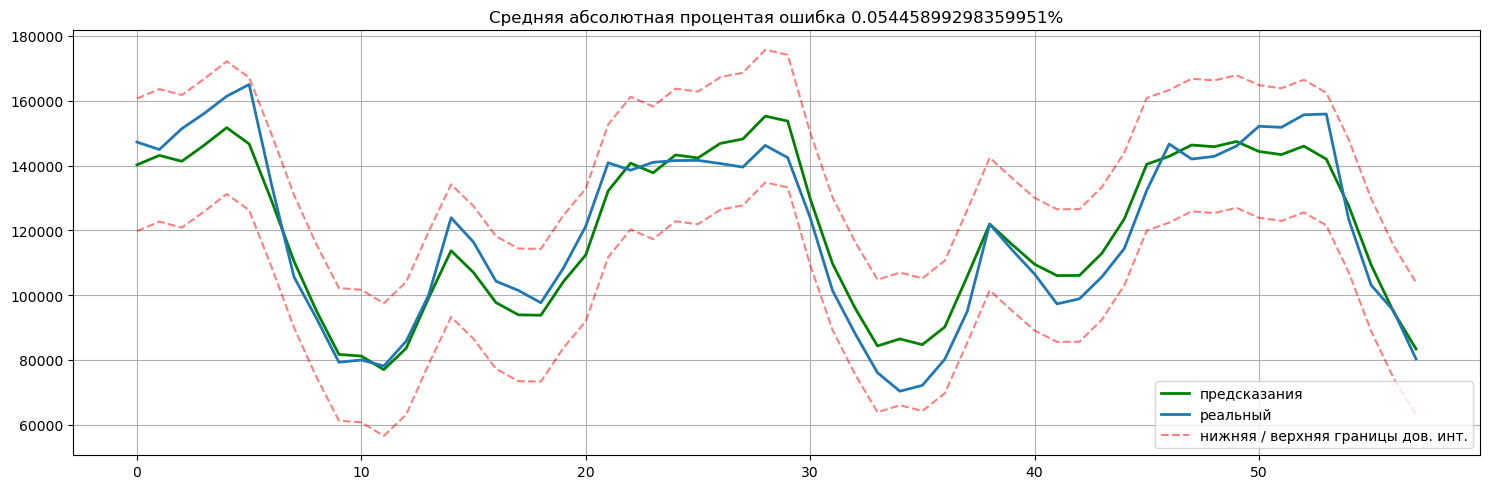

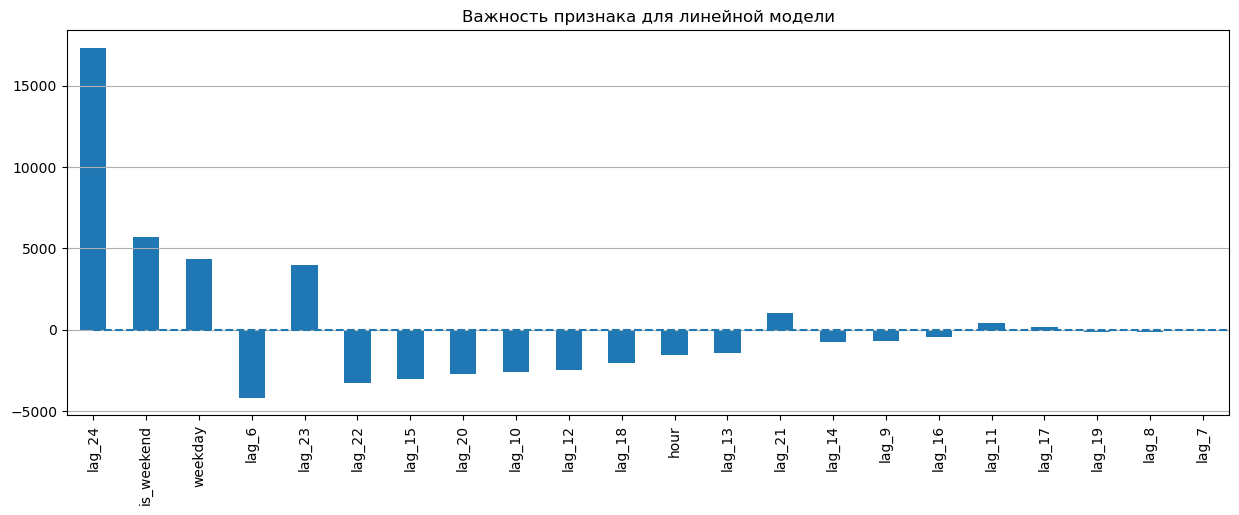

In [27]:
y = data.dropna().target
X = data.dropna().drop(['target'], axis=1)

X_train, X_test, y_train, y_test = time_series_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plot_model_results(lr, X_train = X_train_scaled, X_test = X_test_scaled, plot_conf_intervals = True)
plot_coeff_regression(lr)

### Отбор признаков

#### Корреляционный анализ

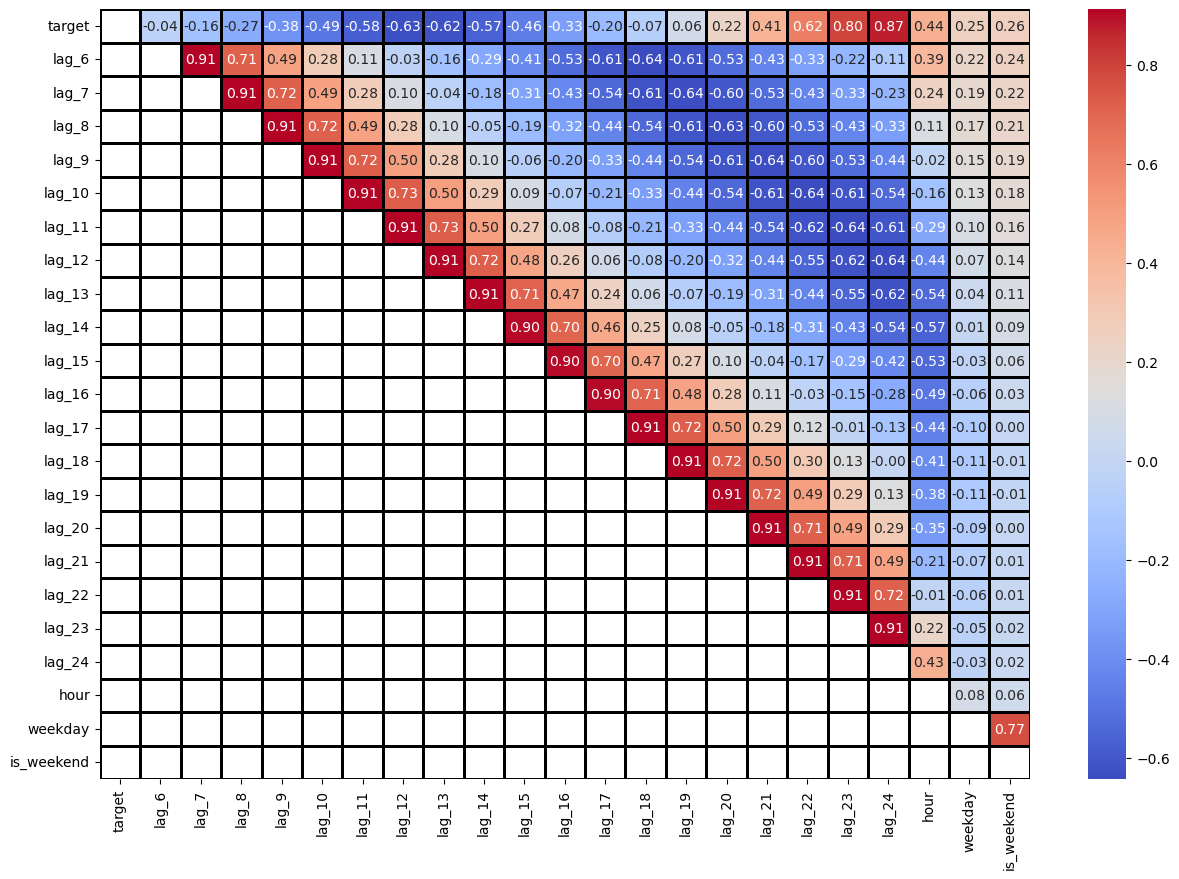

In [28]:
data_to_corr_matrix = pd.concat([y_train, X_train], axis = 1)
mask = np.tril(data_to_corr_matrix.corr()) # маска треугольного вида матрицы

plt.figure(figsize = (15, 10))

sns.heatmap(data_to_corr_matrix.corr(),
            annot = True, # Подписывать числа
            fmt = '0.2f', # округление чисел до сотых
            cmap = 'coolwarm', # цветовая гамма (также 'PiYG' - очень хорошая)
            linewidths=1,   # добавление рамок для ячеек
            linecolor='black',  # цвет этих рамок
            mask = mask)    # добавление маски (треугольник)
plt.show()

#### Ridge отбор для линейных моделей

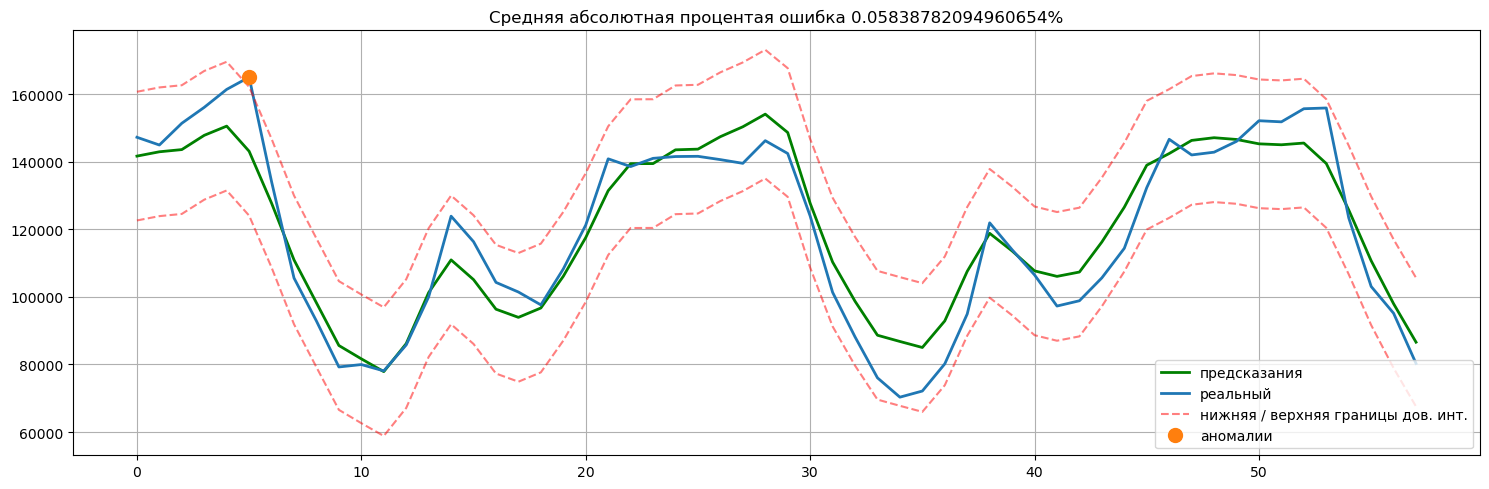

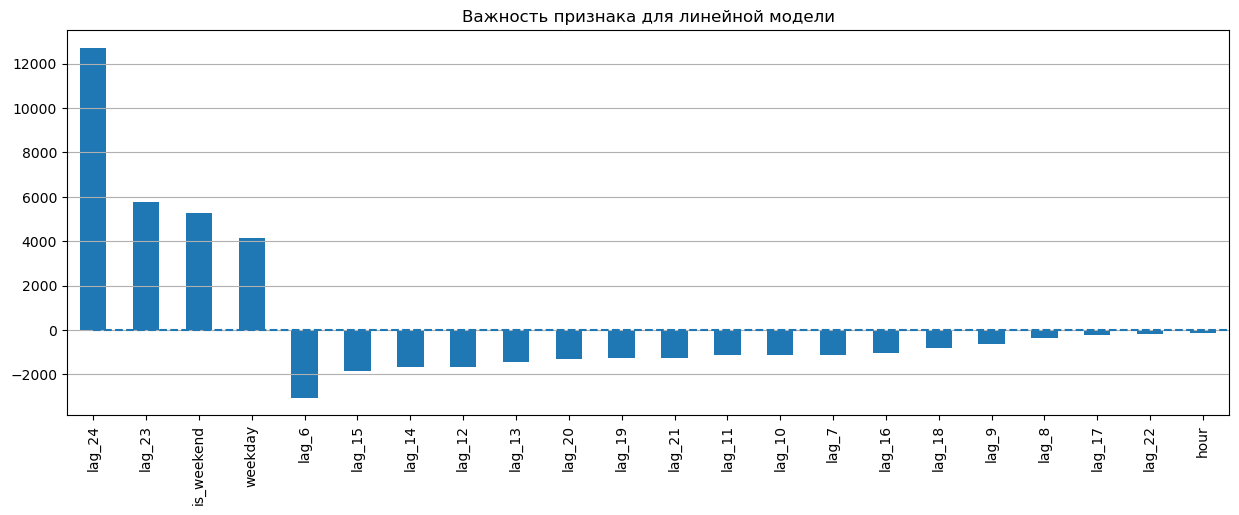

In [29]:
ridge = RidgeCV(cv = time_series_cross_val)
ridge.fit(X_train_scaled, y_train)

plot_model_results(
    ridge, 
    X_train = X_train_scaled, 
    X_test = X_test_scaled, 
    plot_conf_intervals = True,
    plot_anomalies=True)

plot_coeff_regression(ridge)

In [31]:
indexes = X_train.index

#### Рекурсивный отбор признаков

In [32]:
lr = LinearRegression()
rfecv = RFECV(
    estimator = lr,
    step = 1,
    scoring = 'neg_mean_absolute_percentage_error',
    cv = time_series_cross_val,
    verbose = 0
)

rfecv.fit(X_train_scaled, y_train)

RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
      estimator=LinearRegression(),
      scoring='neg_mean_absolute_percentage_error')

In [33]:
new_columns = [X_train.columns[i] for i, v in enumerate(rfecv.support_) if v == True]

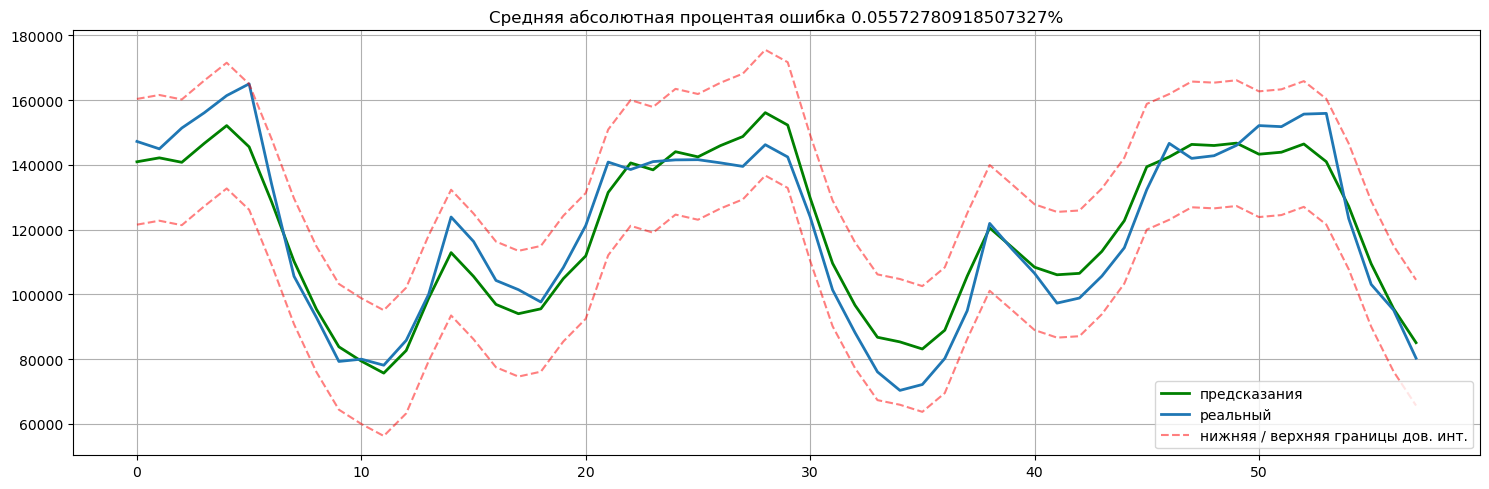

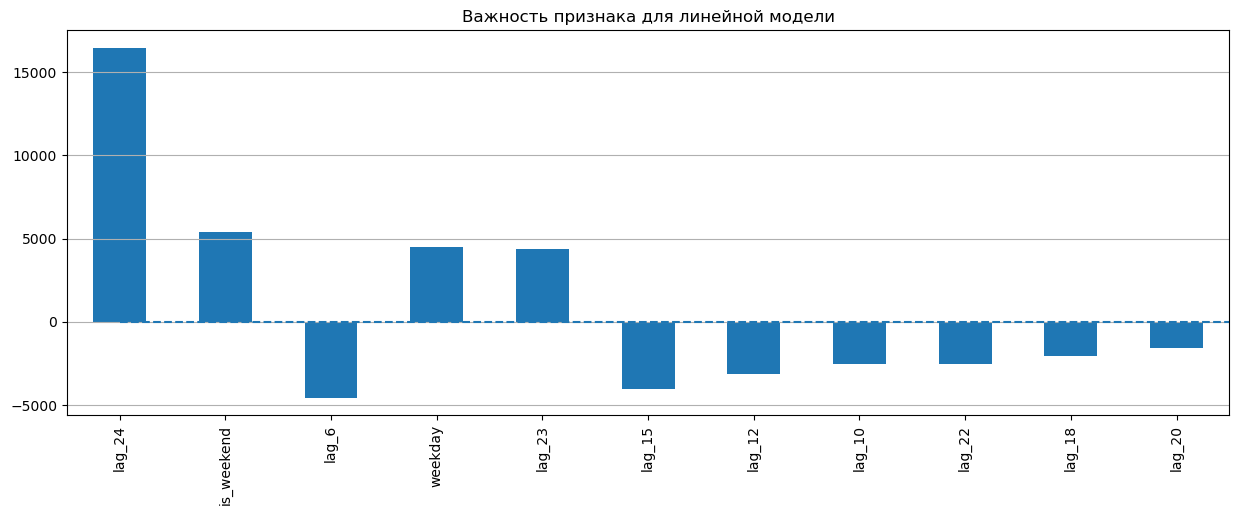

In [34]:
X_train_new = X_train[new_columns]

scaler_1 = StandardScaler()
X_train_new_scaled = scaler_1.fit_transform(X_train_new)

lr_model_2 = LinearRegression()
lr_model_2.fit(X_train_new_scaled, y_train)

X_test = scaler_1.transform(X_test[new_columns])
X_train = X_train_new

plot_model_results(lr_model_2, X_train = X_train, X_test = X_test, plot_conf_intervals = True)
plot_coeff_regression(lr_model_2)

## Rolling mean

In [4]:
data = ads.copy()
data.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [9]:
for window in range(3, 31):
    data['rolling_mean_{}'.format(window)] = data['Ads'].rolling(window = window, min_periods = 0).mean().shift(1)

data = data.dropna()
y = data['Ads']
X = data.drop(['Ads'], axis = 1)

X_train, X_test, y_train, y_test = time_series_train_test_split(X, y, test_size = 0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Catboost

In [37]:
model = cb.CatBoostRegressor(
    has_time = True,
    n_estimators = 50000,
    learning_rate = 0.05,
    max_depth = 3,
    eval_metric = 'MAPE',
    loss_function = 'MAPE',
    l2_leaf_reg = 10,
    use_best_model = True,
    early_stopping_rounds = 1000,
    task_type = 'CPU'
    )
model.fit(X_train,
          y_train,
          eval_set = (X_test, y_test),
          verbose = 0,
          plot = True)

predictions = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"MAPE = {mape:.4f}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAPE = 0.0755


In [38]:
importance_features = model.get_feature_importance(prettified = True)[:10]['Feature Id']
model.get_feature_importance(prettified = True)[:10]

,Feature Id,Importances
0,0,30.871055
1,14,7.912180
2,10,6.457628
3,1,5.513154
4,5,4.659938
5,13,4.459974
6,9,4.426357
7,12,3.850304
8,11,3.612118
9,15,3.322076


In [39]:
data_plus = data.iloc[:, [int(i) for i in importance_features]]

y = data_plus['Ads']
X = data_plus.drop(['Ads'], axis = 1)
X_train, X_test, y_train, y_test = time_series_train_test_split(X, y, test_size = 0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
model_plus = cb.CatBoostRegressor(
    has_time = True,
    n_estimators = 50000,
    learning_rate = 0.05,
    max_depth = 3,
    eval_metric = 'MAPE',
    loss_function = 'MAPE',
    l2_leaf_reg = 10,
    use_best_model = True,
    early_stopping_rounds = 1000,
    task_type = 'CPU'
    )
model_plus.fit(
    X_train,
    y_train,
    eval_set = (X_test, y_test),
    verbose = 0,
    plot = True
    )

predictions = model_plus.predict(X_test)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"MAPE = {mape:.4f}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAPE = 0.0917


In [41]:
data_plus.index = pd.to_datetime(data_plus.index)
data_plus["hour"] = data_plus.index.hour
data_plus["weekday"] = data_plus.index.weekday
data_plus['is_weekend'] = data_plus.weekday.isin([5,6])*1
data_plus.tail()

,Ads,rolling_mean_16,rolling_mean_12,rolling_mean_3,rolling_mean_7,rolling_mean_15,rolling_mean_11,rolling_mean_14,rolling_mean_13,rolling_mean_17,hour,weekday,is_weekend
Time,,,,,,,,,,,,,
2017-09-21 19:00:00,155890,126427.1875,132127.916667,153191.666667,148147.857143,128526.000000,135295.000000,128998.571429,130156.153846,123707.647059,19,3,0
2017-09-21 20:00:00,123395,130236.2500,137011.250000,154448.333333,149470.714286,130791.333333,140479.545455,131994.285714,133955.769231,128160.294118,20,3,0
2017-09-21 21:00:00,103080,130329.0625,139055.833333,144983.333333,146813.571429,131421.000000,142094.090909,133201.428571,135963.846154,129833.823529,21,3,0
2017-09-21 22:00:00,95155,129649.6875,138842.916667,127455.000000,141137.142857,131193.333333,141066.818182,133615.000000,136288.461538,128726.176471,22,3,0
2017-09-21 23:00:00,80285,128940.9375,137240.833333,107210.000000,133870.714286,131051.000000,137686.818182,133350.357143,135482.307692,127620.588235,23,3,0


In [42]:
y = data_plus['Ads']
X = data_plus.drop(['Ads'], axis = 1)
X_train, X_test, y_train, y_test = time_series_train_test_split(X, y, test_size = 0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model_plus_time = cb.CatBoostRegressor(
    has_time = True,
    n_estimators = 50000,
    learning_rate = 0.05,
    max_depth = 3,
    eval_metric = 'MAPE',
    loss_function = 'MAPE',
    l2_leaf_reg = 10,
    use_best_model = True,
    early_stopping_rounds = 1000,
    task_type = 'CPU'
    )
model_plus_time.fit(
    X_train,
    y_train,
    eval_set = (X_test, y_test),
    verbose = 0,
    plot = True
    )

predictions = model_plus_time.predict(X_test)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"MAPE = {mape:.4f}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAPE = 0.0978


# ARIMA / SARIMA


- AR (p) - Модель авторегрессии (AutoRegression). p - максимальный лаг. Чтобы определить начальное значение p, вам нужно посмотреть на график PACF и найти самый большой значимый лаг, после которого большинство других лагов становятся незначительными.

- I (d) - порядок ингегрирования. Это просто число несезонных различий, необходимое для того, чтобы ряд стал стационарным.

- MA(q) – модель скользящей средней. Моделирует ошибку временного ряда, опять же с предположением, что текущая ошибка зависит от предыдущей с некоторой задержкой, которая называется q. Начальное значение можно найти на графике ACF, используя ту же логику, что и раньше.

- P - порядок авторегрессии для сезонной составляюзей модели, который можно получить из PACF. Но нужно смотреть на количество значительных лагов, кратных продолжительности сезона. Например, если период равен 24 и мы видим, что 24-й и 48-й лаги значимы в PACF, это означает, что начальный P должен быть равен 2

- Q - аналогичная логика с использованием вместо этого графика ACF

- D – порядок сезонного интегрирования. Оно может быть равно 1 или 0, в зависимости от того, применялись сезонные разницы или нет.

---
Метрика модели SARIMA - AIC

AIC представляет собой метрику, которая учитывает компромисс между качеством модели и ее сложностью. Чем ниже значение AIC, тем лучше. AIC позволяет проводить сравнительный анализ различных моделей SARIMA с различными параметрами и выбрать ту, которая наилучшим образом балансирует между точностью и сложностью.

Смотрим на графики ACF и PACF



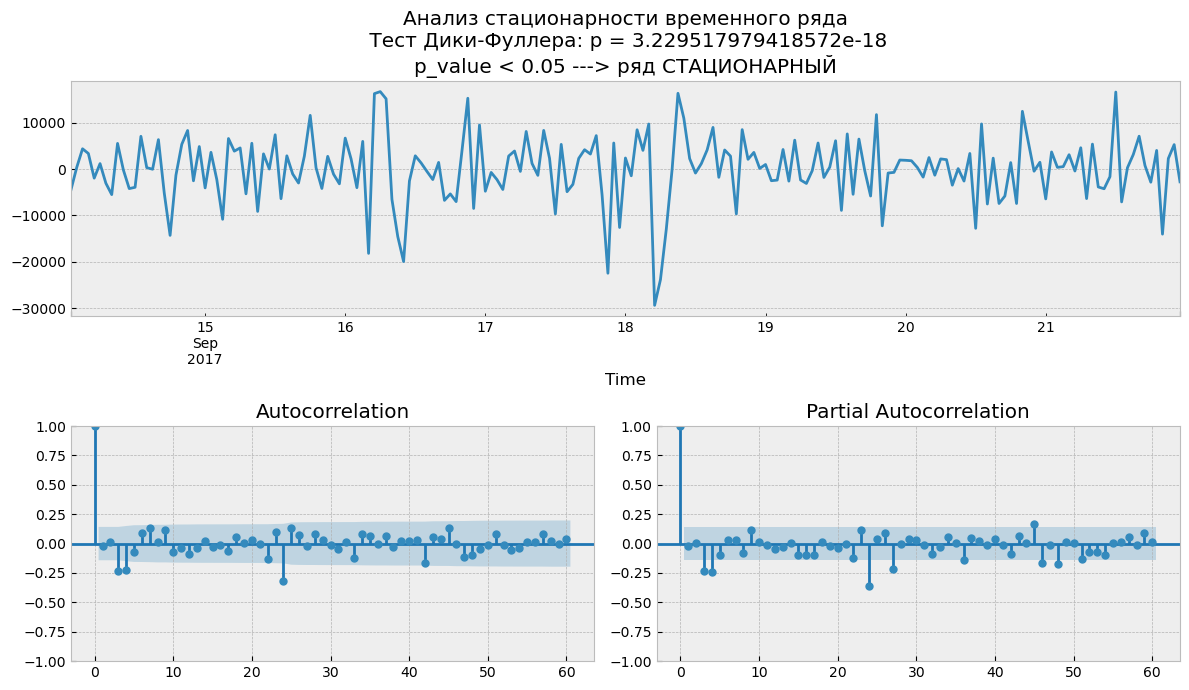

- p = 4 (на графике PACF после него все остальнрые лпги незначительны в данном периоде (24 часа))
- d = 1 (после 1 дифференциирования ряд становился стационарным по тесту Дики-Фуллера)
- q = 4 (аналогично p но посмотрели на ACF)
- P = 2 (24 и 48 лаги значительны на графике PACF)
- D = 1 (сезонная разность применялась)
- Q = 1 (24 лаг значительный на графике ACF, 48 - не особо)

Все это наши предположения из визуального анализа графиков, поэтому сделаем сеточный поиск

In [51]:
some_p = np.arange(2,5)
d = 1
some_q = np.arange(2,5)
some_P = np.arange(0, 2)
D = 1
some_Q = np.arange(0,2)

s = 24 # период сезонности

# все возможные перестановки заданных параметров
parameters = product(some_p, some_q, some_P, some_Q)
parameters = list(parameters)
len(parameters)

36

In [53]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Вернуть фрейм данных с параметрами и соответствующим AIC
        
        parameters_list - список перестановок параметров (p, q, P, Q)
        d - кол-во дифференциирования ряда
        D - сезонная разность (1 или 0)
        s - период сезонности
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # try - except воизбежании ошибок параметров
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1) # disp = -1 подавление вывода информации
        except:
            continue
        aic = model.aic
        # сохранение лучшего
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортировка. Чем ниже AIC, тем лучше
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [54]:
result_table = optimizeSARIMA(parameters, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

In [55]:
result_table.head()

,parameters,aic
0,"(2, 3, 1, 1)",3888.642174
1,"(3, 2, 1, 1)",3888.763568
2,"(4, 2, 1, 1)",3890.279740
3,"(3, 3, 1, 1)",3890.513196
4,"(2, 4, 1, 1)",3892.302849


In [56]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                     seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood               -1936.321
Date:                              Wed, 15 May 2024   AIC                           3888.642
Time:                                      15:26:30   BIC                           3914.660
Sample:                                  09-13-2017   HQIC                          3899.181
                                       - 09-21-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.55

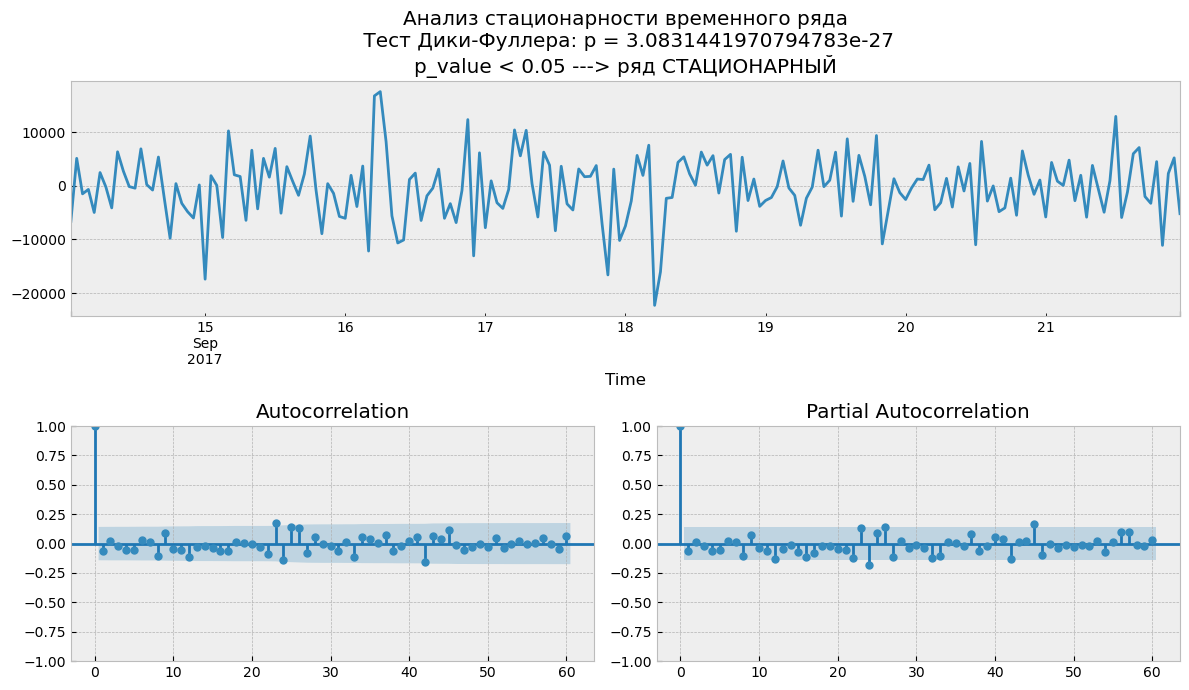

In [60]:
stationarity_analist(best_model.resid[25:], lags = 60)

остатки стационарны, сделаем прогонозы

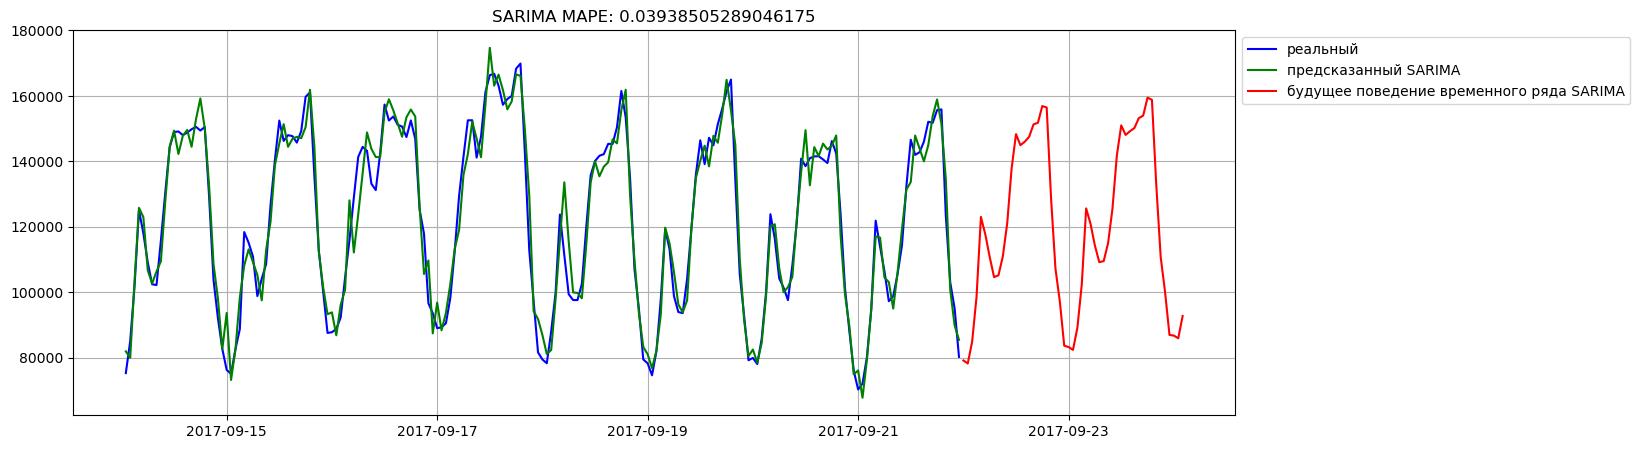

In [106]:
def SARIMA_MAPE(data, model, n_steps):
    """"
        data - dataset с индексами времени
        model - SARIMA model
        n_steps - количество шагов для прогнозирования 
    """
    data = data.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues # значения SARIMA после fit

    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    # вычисляем MAPE сместившись на s+d шагов от начала
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize = (15,5))
    plt.plot(data['actual'][s+d:],
             color = 'b',
             label = 'реальный')
    plt.plot(data['arima_model'][s+d:],
             color = 'g',
             label = 'предсказанный SARIMA')
    plt.plot(forecast,
             color = 'r',
             label = 'будущее поведение временного ряда SARIMA')
    plt.grid(True)
    plt.title('SARIMA MAPE: {}'.format(error))
    plt.legend(bbox_to_anchor=(1, 1))


SARIMA_MAPE(ads, best_model, 50)

# LSTM

## Декомпозиция временного ряда

In [3]:
def plot_decompose(decompose_result):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(20,15))
    decompose_result.observed.plot(legend=False,ax=ax1,fontsize = 20,grid=True,linewidth = 3)
    ax1.set_ylabel("Observed",fontsize = 20)
    decompose_result.trend.plot(legend=False,ax=ax2,fontsize = 20,grid=True,linewidth = 3)
    ax2.set_ylabel("Trend",fontsize = 20)
    decompose_result.seasonal.plot(legend=False,ax=ax3,fontsize = 20,grid=True,linewidth = 3)
    ax3.set_ylabel("Seasonal",fontsize = 20)
    decompose_result.resid.plot(legend=False,ax=ax4,fontsize = 20,grid=True,linewidth = 3)
    ax4.set_ylabel("Residual",fontsize = 20)

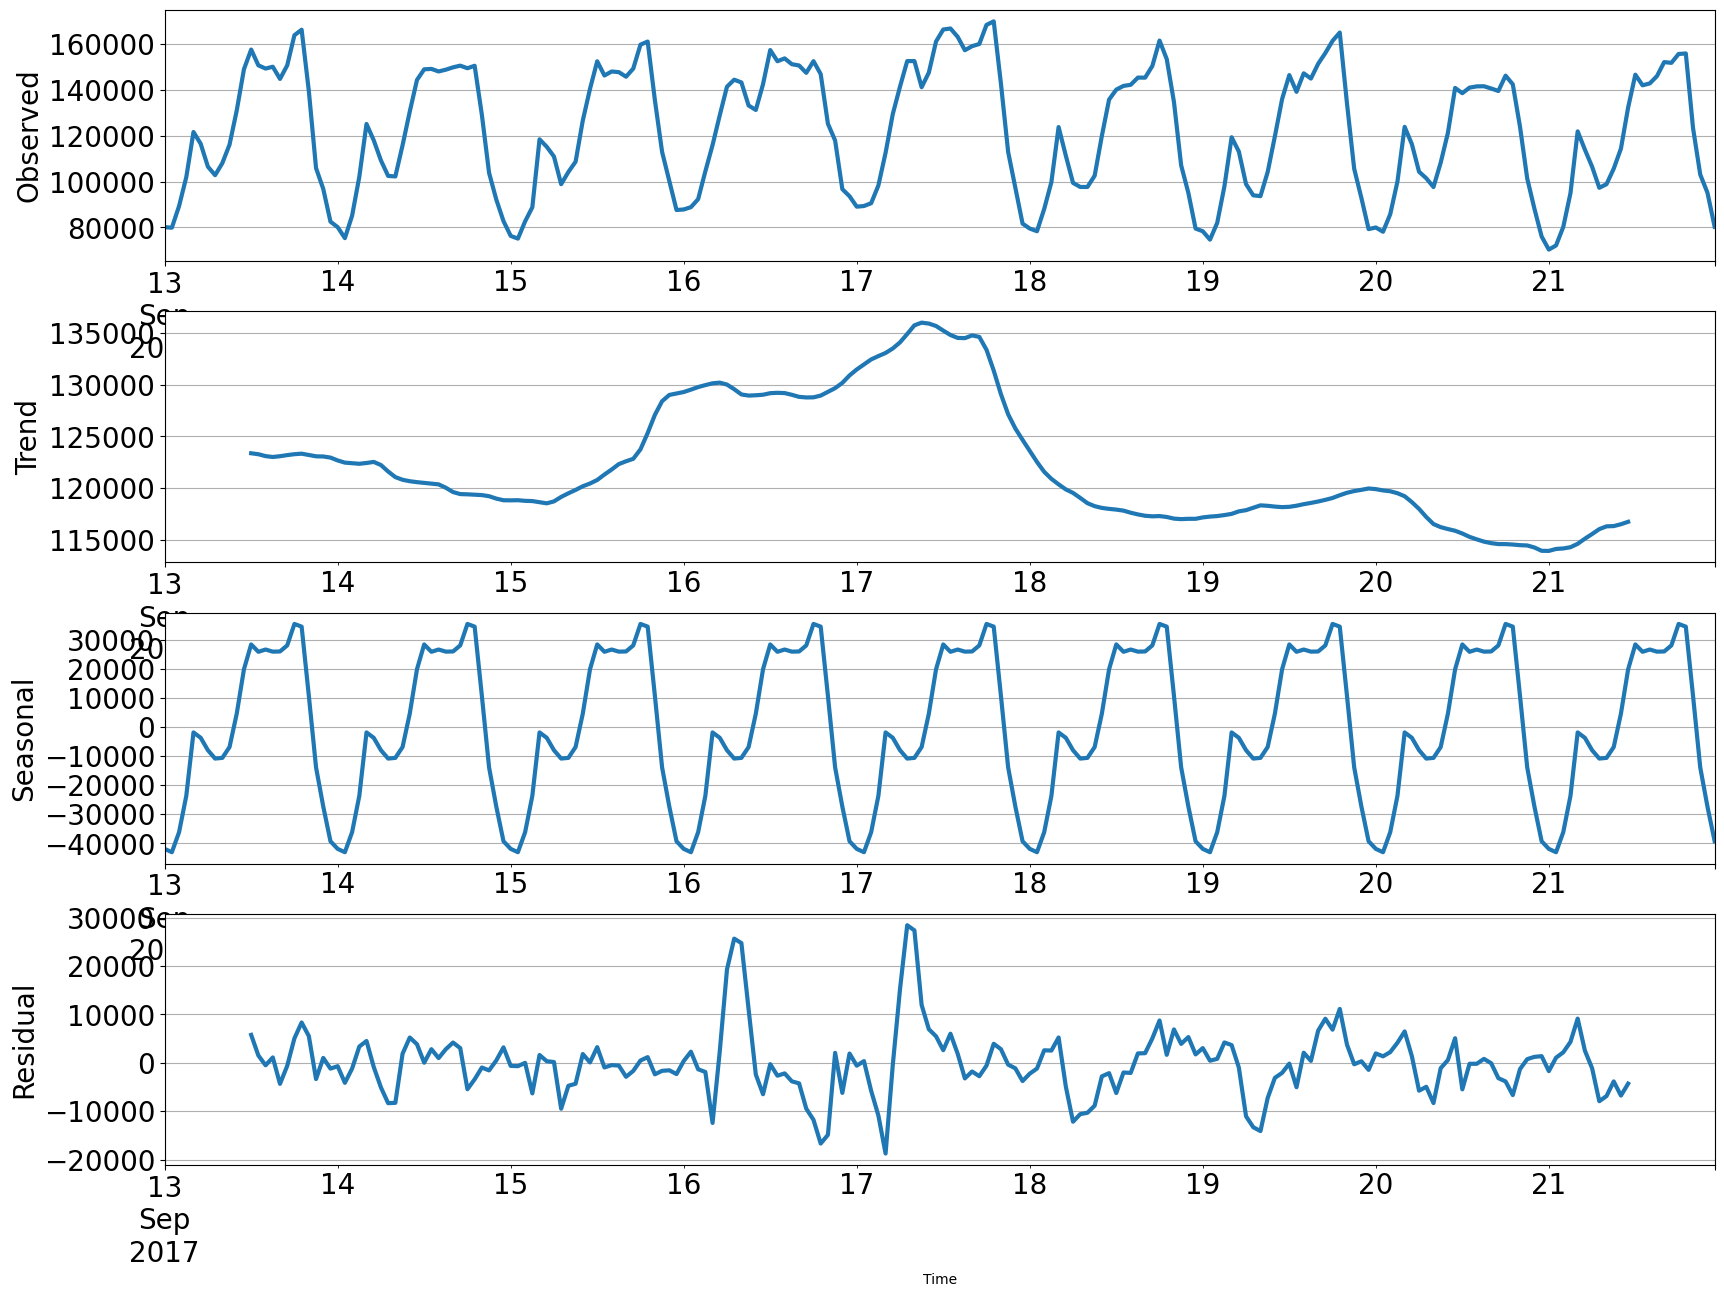

In [5]:
data = ads.copy()

decomposition = seasonal_decompose(data['Ads'])
plot_decompose(decomposition)

In [6]:
def time_series_train_test_split_for_LSTM(X, test_size):

    test_index = int(len(X)*(1 - test_size))

    X_train = X.iloc[:test_index]
    X_test = X.iloc[test_index:]
    
    return X_train, X_test

In [7]:
data = ads.copy()

X_train, X_test = time_series_train_test_split_for_LSTM(data, test_size=0.3)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
def create_inout_sequences(input_data, window):
    inout_seq = []
    L = len(input_data)
    for i in range(L-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window:i+window+1]
        inout_seq.append((torch.tensor(train_seq, dtype = torch.float32),
                          torch.tensor(train_label, dtype = torch.float32)))
        '''inout_seq.append((train_seq, train_label))'''
    return inout_seq

train_chunks = create_inout_sequences(X_train_scaled, 24)
print('Размер входа одной чанки: ', train_chunks[0][0].shape)
print('Размер таргета текущей чанки: ', train_chunks[0][1].shape)

Размер входа одной чанки:  torch.Size([24, 1])
Размер таргета текущей чанки:  torch.Size([1, 1])


## Model

In [12]:
class LSTM(nn.Module):
    def __init__(self,
                 data_shape = train_chunks[0][0].shape,
                 # input_size = 1,
                 hidden_layer_size = 128,
                 num_layers = 1,
                 output_size = 1 # хотим предсказать одно значение (Ads на следующий час)
                 ):
    
        super().__init__()


        self.num_rows, self.num_features = data_shape
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(

            self.num_features, # количество входных признаков
            hidden_layer_size, 
            num_layers = num_layers

            )
        
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions[-1]

In [ ]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model

LSTM(
  (lstm): LSTM(1, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

# Функция L1 L2 регуляризации

In [24]:
def loss_with_l1_or_l2_regulizer(
        
        model,
        type, # Здесь могут быть 3 вида : 'l1', 'l2', 'l1_l2' 
        l_lambda, # 0.001
        loss_by_fn):
    
    if type == 'l2':
        l_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    if type == 'l1':
        l_norm = sum(p.abs().sum() for p in model.parameters())

    if type == 'l1_l2':
        l_norm = sum((p.abs() + p.pow(2.0)).sum() for p in model.parameters())
    
    loss_plus_reg = loss_by_fn + l_lambda * l_norm
    return loss_plus_reg

# Training loop

In [25]:
def training_loop(
        epoches,
        model,
        optimizer,
        scheduler,
        loss_fn,
        train_dataloader,
        val_dataloader,

        # regulizer
        regulizer,
        reg_type,
        
        # stop settings
        stop_mode,
        each__X__epoch,
        min_delta,
        patience,

        # verbose
        verbose_epoch
        ):
    
    loss_train_list = []
    loss_test_list = []
    MAPE_train_list = []
    MAPE_val_list = []
    best_loss = float('inf')
    patience_beginner = patience

    model = model.to(device)

    for epoch in range(1, epoches+1):
            
            start_time = time.time()
            loss_train = 0.0
            loss_val = 0.0
            APE_train = 0.0
            APE_val = 0.0

            for features, labels in train_dataloader:
                
                model.train()
                features = features.to(device)
                labels = labels.to(device)
                outputs = model(features)

                # Тренировочный потери
                loss = loss_fn(outputs, labels)
                
                if regulizer:
                        loss = loss_with_l1_or_l2_regulizer(
                                model = model,
                                type = reg_type,
                                l_lambda = 0.001,
                                loss_by_fn = loss
                                )
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                Y_pred = scaler.inverse_transform(outputs.cpu().detach().numpy().reshape(1,-1)).item()
                Y_real = scaler.inverse_transform(labels.cpu().detach().numpy()).item()
                APE_train += abs(Y_real - Y_pred) / Y_real

                loss_train += loss.item()
                
            
            mean_epoch_loss = loss_train/len(train_dataloader)
            loss_train_list.append(mean_epoch_loss)

            epoch_train_MAPE = 100*(APE_train / len(train_dataloader))
            MAPE_train_list.append(epoch_train_MAPE)
                
            # Проверочный этап
            model.eval()
            with torch.no_grad():
                                for features, labels in val_dataloader:
                                        features = features.cuda()
                                        labels = labels.cuda()
                                        outputs = model(features)
                                        loss = loss_fn(outputs, labels)

                                        Y_pred = scaler.inverse_transform(outputs.cpu().detach().numpy().reshape(1,-1)).item()
                                        Y_real = scaler.inverse_transform(labels.cpu().detach().numpy()).item()
                                        APE_val += abs(Y_real - Y_pred) / Y_real
                                        loss_val += loss.item()

                                mean_epoch_loss_val = loss_val / len(val_dataloader)
                                loss_test_list.append(mean_epoch_loss_val)

                                epoch_val_MAPE = 100*(APE_val / len(val_dataloader))
                                MAPE_val_list.append(epoch_val_MAPE)
            # EARLY STOPPING #######################################
            if stop_mode:
                if epoch % each__X__epoch == 0:
                        current_loss = mean_epoch_loss
                        if current_loss < best_loss - min_delta:
                                best_loss = current_loss
                                patience = patience_beginner
                        else:
                                patience -= 1
                                if patience == 0:
                                        print(f"Ранняя тренировочная остановка на {epoch} эпохе")
                                        break
            ##############################################################
            scheduler.step(mean_epoch_loss)
            ##############################################################
            end_time = time.time()
            epoch_time = end_time - start_time
            расчетное_время_выполнения_цикла = (epoch_time*epoches) / 60
            ############ VERBOSE #########################################
            if epoch == 1:
                   print('Расчетное время выполнения всего цикла {:.3f} минут'.format(расчетное_время_выполнения_цикла))            
            if epoch == 1 or epoch % verbose_epoch == 0:
                print(
                        'Epoch {:5}/{:5} || time: {:.3f} || train loss: {:.3f} || val_loss: {:.3f} || train MAPE: {:.3f} || val MAPE: {:.3f}'
                        .format(epoch,
                                epoches,
                                epoch_time,
                                mean_epoch_loss,
                                mean_epoch_loss_val,
                                epoch_train_MAPE,
                                epoch_val_MAPE
                                )     
                      )
            ################################################################
    ###### PLOTTING #############################################################################
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_train_list,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_test_list,
                 label = 'val')
    plt.title('Потери от эпох: epoches: {}   lr: {}'.format(epoches,
                                                            optimizer.param_groups[0]['lr']))
    plt.xlabel('эпохи')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

    sns.lineplot(x = np.arange(1, epoch+1),
                 y = MAPE_train_list,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = MAPE_val_list,
                 label = 'val')
    
    plt.xlabel('эпохи')
    plt.ylabel('MAPE')
    plt.title('MAPE on train: {}   lr: {}'\
              .format(
                      epoches,
                      optimizer.param_groups[0]['lr']
                      )
                      )
    plt.legend()
    plt.grid()
    plt.show()
    
    return model

## Первая проба (Adam, без scheduler, без регуляризации)

Расчетное время выполнения всего цикла 14.204 минут
Epoch     1/ 2000 || time: 0.426 || train loss: 0.756 || val_loss: 0.342 || train MAPE: 18.699 || val MAPE: 13.409
Epoch   100/ 2000 || time: 0.301 || train loss: 0.018 || val_loss: 0.029 || train MAPE: 2.464 || val MAPE: 3.361
Epoch   200/ 2000 || time: 0.307 || train loss: 0.008 || val_loss: 0.030 || train MAPE: 1.625 || val MAPE: 3.386
Epoch   300/ 2000 || time: 0.341 || train loss: 0.001 || val_loss: 0.033 || train MAPE: 0.651 || val MAPE: 3.253
Epoch   400/ 2000 || time: 0.285 || train loss: 0.000 || val_loss: 0.031 || train MAPE: 0.196 || val MAPE: 3.048
Epoch   500/ 2000 || time: 0.300 || train loss: 0.000 || val_loss: 0.036 || train MAPE: 0.244 || val MAPE: 3.225
Ранняя тренировочная остановка на 600 эпохе


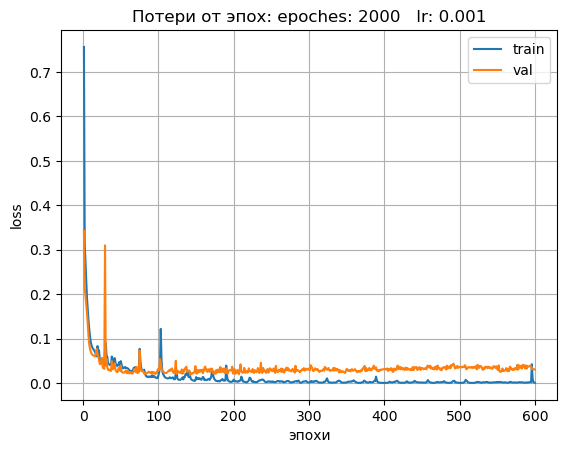

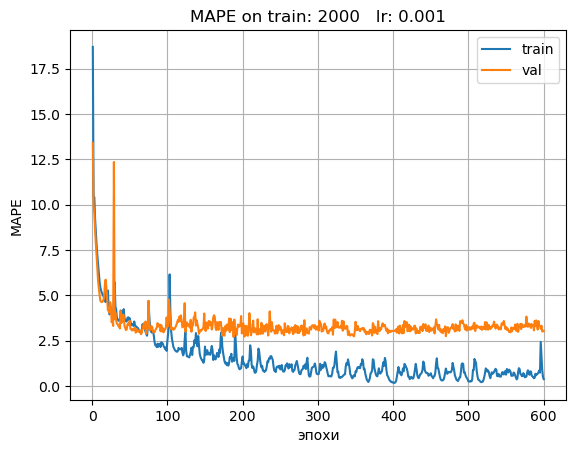

In [17]:
train_chunks = create_inout_sequences(X_train_scaled, 24)
val_chunks = create_inout_sequences(X_test_scaled, 24)

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


model = training_loop(

    epoches = 2000,
    model = model,
    optimizer = optimizer,
    loss_fn = loss_function,
    train_dataloader = train_chunks,
    val_dataloader = val_chunks,
    regulizer = False,
    reg_type = 'l2',
    stop_mode = True,
    each__X__epoch = 20,
    min_delta = 0.001,
    patience = 10,
    verbose_epoch = 100
    
)

## Вторая проба

Расчетное время выполнения всего цикла 20.345 минут
Epoch     1/ 2000 || time: 0.610 || train loss: 0.852 || val_loss: 0.411 || train MAPE: 18.778 || val MAPE: 14.936
Epoch   100/ 2000 || time: 0.416 || train loss: 0.078 || val_loss: 0.035 || train MAPE: 3.987 || val MAPE: 3.669
Epoch   200/ 2000 || time: 0.417 || train loss: 0.065 || val_loss: 0.036 || train MAPE: 3.279 || val MAPE: 3.897
Epoch   300/ 2000 || time: 0.415 || train loss: 0.058 || val_loss: 0.028 || train MAPE: 3.012 || val MAPE: 3.410
Epoch   400/ 2000 || time: 0.401 || train loss: 0.054 || val_loss: 0.025 || train MAPE: 2.813 || val MAPE: 3.205
Epoch   500/ 2000 || time: 0.418 || train loss: 0.048 || val_loss: 0.023 || train MAPE: 2.516 || val MAPE: 3.064
Epoch   600/ 2000 || time: 0.426 || train loss: 0.047 || val_loss: 0.024 || train MAPE: 2.428 || val MAPE: 3.122
Epoch   700/ 2000 || time: 0.419 || train loss: 0.045 || val_loss: 0.025 || train MAPE: 2.342 || val MAPE: 3.267
Epoch   800/ 2000 || time: 0.413 || train 

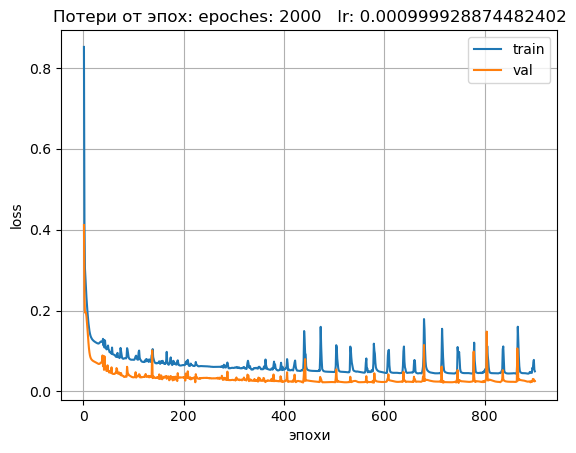

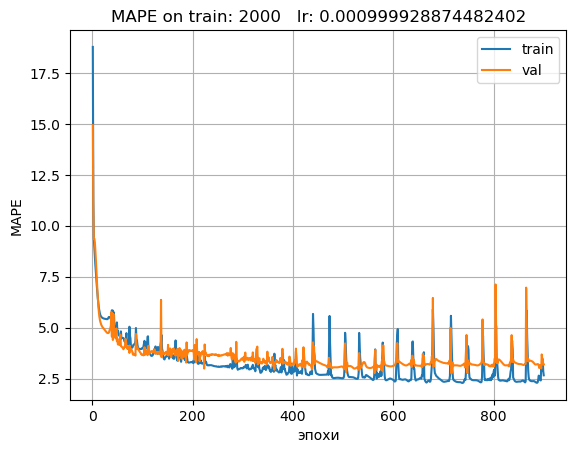

In [26]:
train_chunks = create_inout_sequences(X_train_scaled, 24)
val_chunks = create_inout_sequences(X_test_scaled, 24)

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0, last_epoch=-1)


model = training_loop(

    epoches = 2000,
    model = model,
    optimizer = optimizer,
    loss_fn = loss_function,
    train_dataloader = train_chunks,
    val_dataloader = val_chunks,
    scheduler = scheduler,
    regulizer = True,
    reg_type = 'l2',
    stop_mode = True,
    each__X__epoch = 20,
    min_delta = 0.001,
    patience = 10,
    verbose_epoch = 100
)

# Вывод

из все метрик, наилучшую показала модель SARIMA, MAPE = 0.039